In [2]:
from typing import List, Dict
import torch

import sys 
sys.path.append("Attend-and-Excite")

from pipeline_attend_and_excite import AttendAndExcitePipeline
from config import RunConfig
from run import run_on_prompt, get_indices_to_alter
from utils import vis_utils
from utils.ptp_utils import AttentionStore

%load_ext autoreload 
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Load Model Weights (may take a few minutes)

In [3]:
NUM_DIFFUSION_STEPS = 50
GUIDANCE_SCALE = 7.5
MAX_NUM_WORDS = 77
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
stable = AttendAndExcitePipeline.from_pretrained("stabilityai/stable-diffusion-2-1-base",safety_checker=None).to(device)
tokenizer = stable.tokenizer

Fetching 13 files:   0%|          | 0/13 [00:00<?, ?it/s]

/home/akirchme/.conda/envs/diff2/lib/python3.10/site-packages/transformers/models/clip/feature_extraction_clip.py:28: FutureWarning: The class CLIPFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use CLIPImageProcessor instead.
  warnings.warn(


# Pipeline Wrapper

In [4]:
# configurable parameters (see RunConfig for all parameters)
# scale factor - intensity of shift by gradient
# thresholds - a dictionary for iterative refinement mapping the iteration number to the attention threshold
# max_iter_to_alter- maximal inference timestep to apply Attend-and-Excite
def run_and_display(prompts: List[str],
                    controller: AttentionStore,
                    indices_to_alter: List[int],
                    generator: torch.Generator,
                    run_standard_sd: bool = False,
                    scale_factor: int = 20,
                    thresholds: Dict[int, float] = {10: 0.5, 20: 0.8},
                    max_iter_to_alter: int = 25,
                    display_output: bool = False):
    config = RunConfig(prompt=prompts[0],
                       run_standard_sd=run_standard_sd,
                       scale_factor=scale_factor,
                       thresholds=thresholds,
                       max_iter_to_alter=max_iter_to_alter)
    image = run_on_prompt(model=stable,
                          prompt=prompts,
                          controller=controller,
                          token_indices=indices_to_alter,
                          seed=generator,
                          config=config)
    if display_output:
        display(image)
    return image

# Show Cross-Attention Per Strengthened Token

## Define your seeds, prompt and the indices to strengthen

In [5]:
prompt = "an elephant with a crown"
seeds = [21]

In [6]:
token_indices = list(range(1, 6))


## Stable Diffusion

  0%|          | 0/51 [00:00<?, ?it/s]

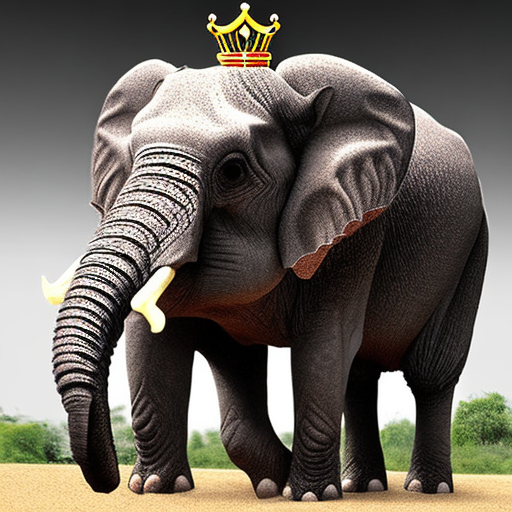

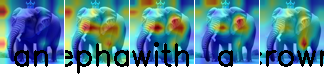

  0%|          | 0/51 [00:00<?, ?it/s]

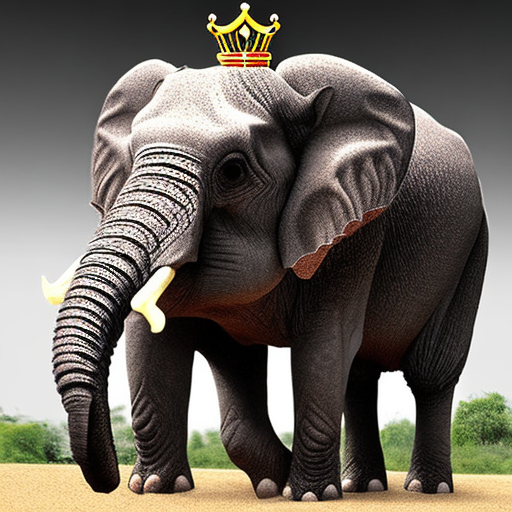

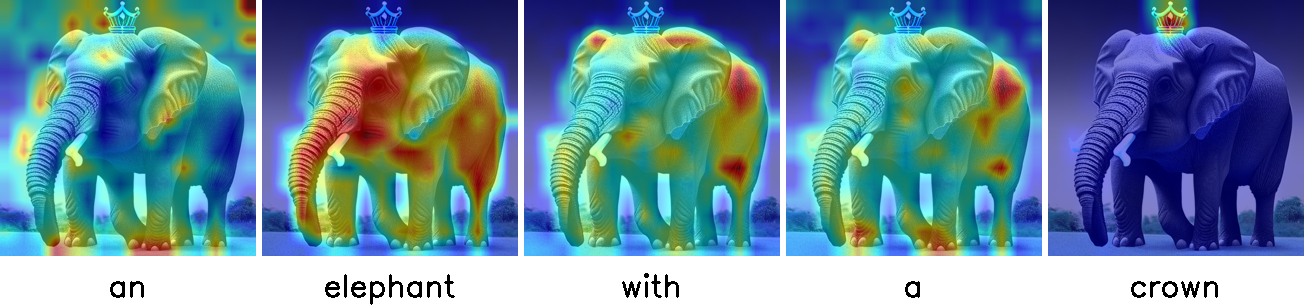

  0%|          | 0/51 [00:00<?, ?it/s]

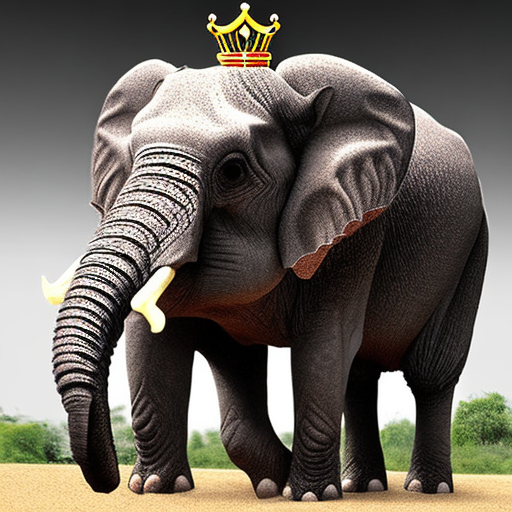

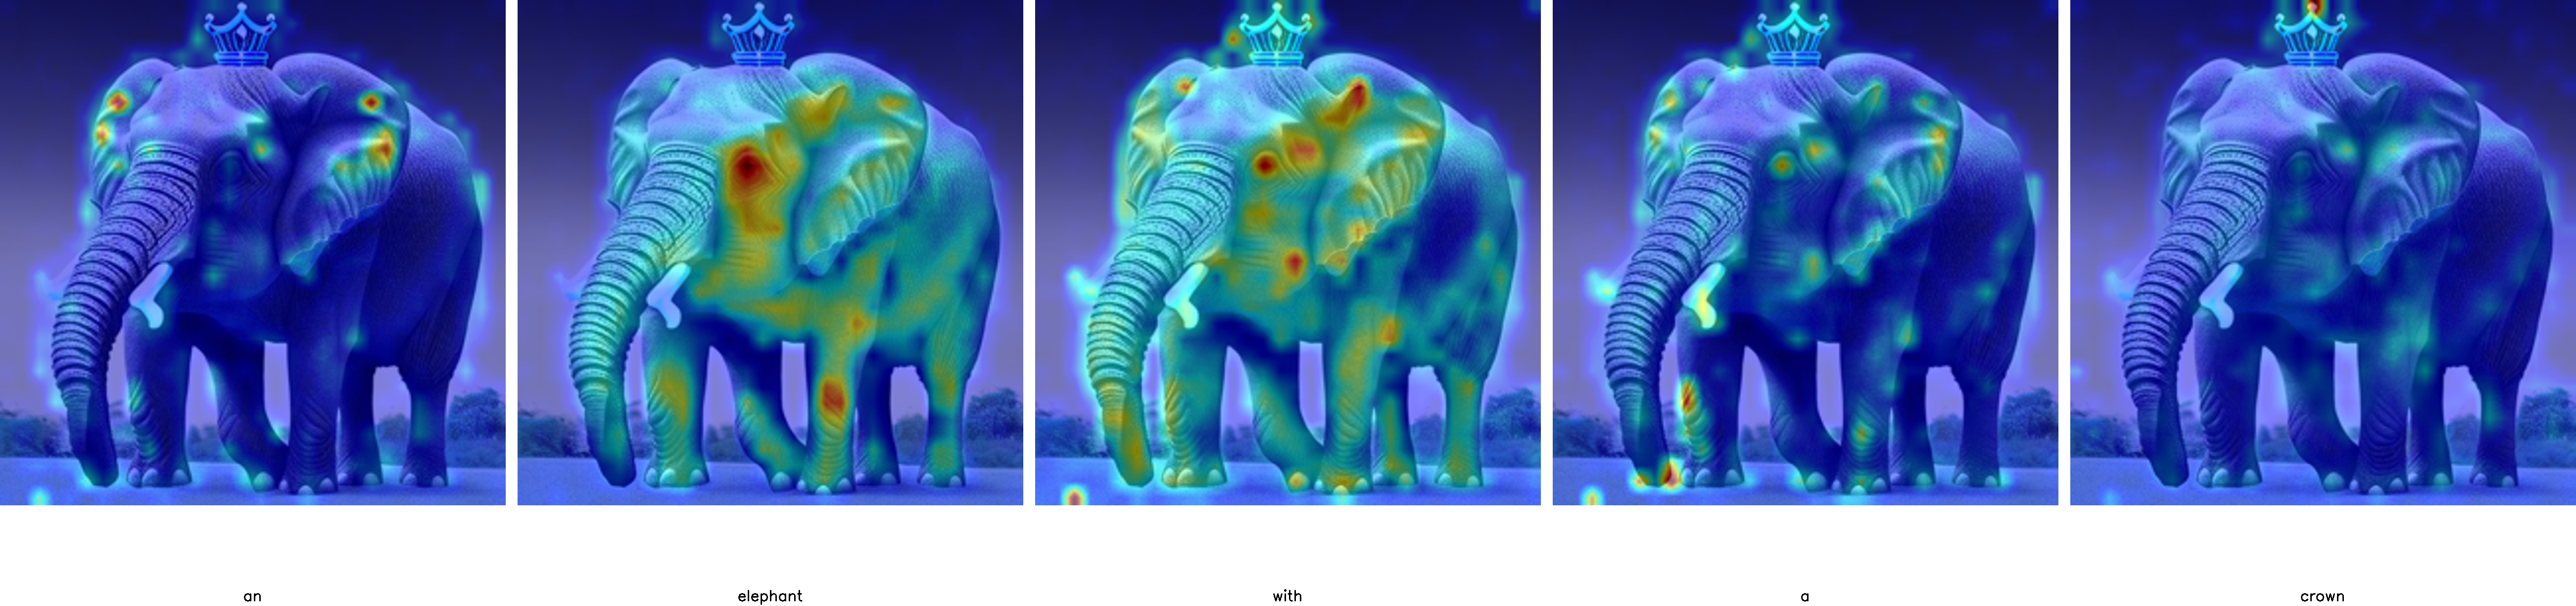

In [7]:
for seed in seeds:
    for res in [8, 16, 32]:
        g = torch.Generator('cuda').manual_seed(seed)
        prompts = [prompt]
        controller = AttentionStore()
        image = run_and_display(prompts=prompts,
                                controller=controller,
                                indices_to_alter=token_indices,
                                generator=g,
                                run_standard_sd=True,
                                display_output=True)
        vis_utils.show_cross_attention(attention_store=controller,
                               prompt=prompt,
                               tokenizer=tokenizer,
                               res=res,
                               from_where=("up", "down", "mid"),
                               indices_to_alter=token_indices,
                               orig_image=image)